## Dog Breed

In [ ]:
# Based on the fast.ai course

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need. We'll learn about what each does during the course.

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/dogbreed/"
arch = resnet101
bs = 58

In [5]:
sz=299

In [6]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n)
print(label_csv)

data/dogbreed/labels.csv


## Initial Data Exploration

In [9]:
!ls {PATH}

labels.csv  sample_submission.csv  test  train


In [13]:
label_df = pd.read_csv(label_csv)

In [14]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [15]:
label_df.pivot_table(index = 'breed', aggfunc=len).sort_values('id', ascending = False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [16]:
tfms = tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom = 1.1)
data = ImageClassifierData.from_csv(PATH, "train", f'{PATH}labels.csv', test_name = "test", val_idxs = val_idxs, 
                                    tfms = tfms, suffix = ".jpg", bs = bs )

In [21]:
#filename for one file in the train data. trn_ds gives you the train dataset
filename1 = PATH+data.trn_ds.fnames[2]; filename1

'data/dogbreed/train/00214f311d5d2247d5dfe4fe24b2303d.jpg'

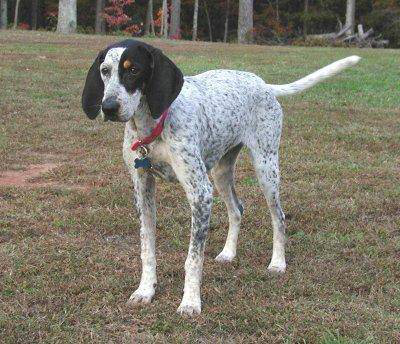

In [22]:
img = PIL.Image.open(filename1); img

In [23]:
img.size

(400, 344)

In [25]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [26]:
row_sz, col_sz = list(zip(*size_d.values()))

In [27]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [28]:
row_sz[:5]

array([500, 500, 400, 500, 231])

(array([ 3014.,  5029.,    91.,    12.,     8.,     3.,    17.,     1.,     1.,     2.]),
 array([   97. ,   413.7,   730.4,  1047.1,  1363.8,  1680.5,  1997.2,  2313.9,  2630.6,  2947.3,  3264. ]),
 <a list of 10 Patch objects>)

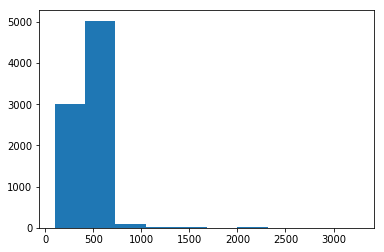

In [29]:
plt.hist(row_sz)

(array([  148.,   600.,  1307.,  1205.,  4581.,   122.,    78.,    62.,    15.,     7.]),
 array([  97. ,  186.3,  275.6,  364.9,  454.2,  543.5,  632.8,  722.1,  811.4,  900.7,  990. ]),
 <a list of 10 Patch objects>)

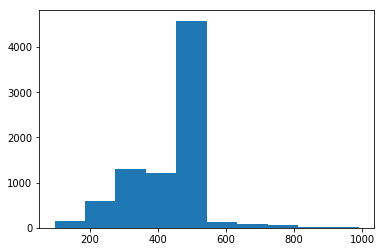

In [31]:
plt.hist(row_sz[row_sz<1000])

(array([  243.,   721.,  2218.,  2940.,  1837.,    95.,    29.,    29.,     8.,     8.]),
 array([ 102. ,  190.2,  278.4,  366.6,  454.8,  543. ,  631.2,  719.4,  807.6,  895.8,  984. ]),
 <a list of 10 Patch objects>)

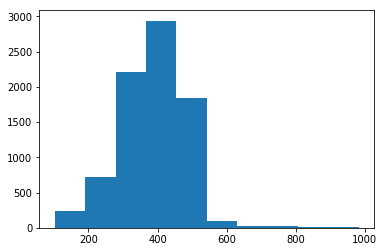

In [32]:
plt.hist(col_sz[col_sz<1000])

In [34]:
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

In [35]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

In [36]:
type(data.classes)

list

## 3. Initial Model

In [8]:
def get_data(sz, bs):
        tfms = tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom = 1.1)
        data = ImageClassifierData.from_csv(PATH, "train", f'{PATH}labels.csv', test_name = "test", 
                                            val_idxs = val_idxs, tfms = tfms, suffix = ".jpg", bs = bs )
        return data if sz>300 else data.resize(340, "tmp")

### 3.1 Precompute

In [10]:
data = get_data(sz,bs)

learn = ConvLearner.pretrained(arch, data, precompute=True)


A Jupyter Widget

In [ ]:
learn.fit(1e-2, 5)

### 3.2 Augment

In [39]:
from sklearn import metrics

In [40]:
data = get_data(sz,bs)

A Jupyter Widget

In [41]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps = 0.5)

In [43]:
learn.fit(1e-2, 2)

A Jupyter Widget

[ 0.       2.04456  1.37019  0.63821]                       
[ 1.       1.4818   1.23063  0.6588 ]                       



In [44]:
learn.precompute = False

In [46]:
learn.fit(1e-2, 5, cycle_len = 1)

A Jupyter Widget

[ 0.       1.36723  1.17426  0.67077]                       
[ 1.       1.37956  1.16263  0.67132]                       
[ 2.       1.34285  1.15454  0.67317]                       
[ 3.       1.29767  1.15235  0.66359]                       
[ 4.       1.26587  1.1371   0.67789]                       



In [11]:
#learn.save("224.pre")

array([[ -0.02109,  -3.86954],
       [ -0.00005,  -9.91835],
       [ -0.00001, -11.1595 ],
       [ -0.00024,  -8.34448],
       [ -0.00008,  -9.39493],
       [ -0.00631,  -5.06912],
       [ -0.00002, -11.01133],
       [ -0.00004, -10.16935],
       [ -0.00003, -10.40165],
       [ -0.00844,  -4.77932]], dtype=float32)

In [12]:
#learn.load("224_pre")

### 3.3 Increase size

In [47]:
learn.set_data(get_data(224, bs))

A Jupyter Widget


100%|██████████| 179/179 [02:06<00:00,  1.41it/s]


In [48]:
learn.freeze() # Just making sure all but last layers are frozen 

In [49]:
learn.fit(1e-2, 5, cycle_len =1)

A Jupyter Widget

[ 0.       0.56228  0.40055  0.88307]                        
[ 1.       0.53385  0.37296  0.89272]                        
[ 2.       0.48114  0.36019  0.8893 ]                        
[ 3.       0.44746  0.34718  0.89607]                        
[ 4.       0.4325   0.34279  0.89847]                        



In [50]:
learn.save("224.pre")

In [51]:
learn.load("224.pre")


In [52]:
learn.set_data(get_data(299, bs))


A Jupyter Widget


100%|██████████| 179/179 [04:15<00:00,  1.43s/it]


In [53]:
learn.fit(1e-2, 5, cycle_len =1)


A Jupyter Widget

[ 0.       0.42475  0.32366  0.90894]                        
[ 1.       0.41189  0.30954  0.91373]                        
[ 2.       0.38108  0.3075   0.91325]                        
[ 3.       0.36435  0.30505  0.91277]                        
[ 4.       0.34984  0.29859  0.91277]                        



In [54]:
learn.save("299.pre")


In [55]:
learn.load("299.pre")


#### Check the training loss vs. validation loss (to see if we should use cycle mult)

In [56]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult =2)


A Jupyter Widget

[ 0.       0.32952  0.29285  0.91325]                        
[ 1.       0.33042  0.29113  0.91229]                        
[ 2.       0.32257  0.28906  0.91325]                        
[ 3.       0.32722  0.29076  0.91037]                        
[ 4.       0.30204  0.2843   0.90894]                        
[ 5.       0.2765   0.28015  0.90941]                        
[ 6.       0.26576  0.27902  0.91085]                        



In [57]:
learn.save('299m.pre')

In [58]:
learn.load('299m.pre')

In [ ]:
log_preds,y = learn.TTA()
probs = exp(log_preds)
accuracy(log_preds, y), metrics.log_loss(y, probs) 


In [59]:
learn.fit(1e-2, 1, cycle_len=1, cycle_mult =2)

A Jupyter Widget

[ 0.       0.26996  0.27962  0.91325]                        



In [61]:
log_preds,y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds, y), metrics.log_loss(y, probs)


(0.91536203522504889, 0.27601836096625199)

In [63]:
learn.save('299m.pre')

In [11]:
learn.load('299m.pre')

While copying the parameter named 0.weight, whose dimensions in the model are torch.Size([4096]) and whose dimensions in the checkpoint are torch.Size([64, 3, 7, 7]), ...


RuntimeError: invalid argument 2: sizes do not match at /opt/conda/conda-bld/pytorch_1503965122592/work/torch/lib/THC/THCTensorCopy.cu:31

### Run the whole dataset without val data

In [68]:
def get_data1(sz, bs):
        tfms = tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom = 1.1)
        data = ImageClassifierData.from_csv(PATH, "train", f'{PATH}labels.csv', test_name = "test", 
                                            tfms = tfms, suffix = ".jpg", bs = bs )
        return data if sz>300 else data.resize(340, "tmp")
    

In [69]:
learn.set_data(get_data1(224, bs))



IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
lrf=learn.lr_find()


In [ ]:
learn.fit(le-2, 3, cycle_len = 2)


In [ ]:
learn.save('224_full.pre')


In [ ]:
learn.load('224_full.pre')


In [ ]:
learn.set_data(get_data1(299, bs))

In [ ]:
learn.fit(le-2, 3, cycle_len = 2)

In [ ]:
learn.save('229_full.pre')

In [ ]:
learn.load('229_full.pre')

## Predict Results For Test Set

In [71]:
test_log_preds, y = learn.TTA(is_test=True)


In [81]:
test_log_preds.shape

(10357, 120)

In [91]:
#save_array(PATH + 'test_preds.dat', test_log_preds)

In [83]:
test_log_preds[:2]

array([[-14.5545 , -11.85919, -16.96289, -13.35121, -18.19089, -17.30975, -17.71014, -15.70761, -15.11924,
        -17.12365, -11.03718, -14.58047, -15.29596, -13.75549, -16.40522, -17.23717, -19.0388 , -15.74505,
        -18.3961 , -17.62435, -10.6888 , -18.13001, -17.12013, -16.50604, -17.0648 , -17.18263, -18.80439,
        -17.29408, -14.39172, -16.51419, -15.94582, -14.81599, -11.74841, -17.14433, -10.51661, -14.61055,
        -15.0822 , -19.17631, -16.03893, -14.77953, -17.65616, -16.33471, -17.07584, -18.10305, -15.92304,
        -16.94559, -20.68336, -15.59494, -15.29274, -16.75748, -13.40525, -17.30662, -16.65327, -18.26654,
        -15.22228, -15.40342, -12.99904, -16.94923,  -0.00155, -15.92426, -16.41962, -15.20121, -17.50824,
        -17.1042 , -10.0909 , -12.74147, -15.99106, -18.33909, -12.98137, -17.43495, -17.02456, -17.45132,
        -18.52887, -14.71227, -12.99877, -17.9539 ,  -7.94395, -15.91495, -13.90051, -17.66058, -19.63507,
        -17.0345 , -15.83572, -11.920

In [92]:
test_probs = np.exp(test_log_preds)


In [ ]:
#test_preds = np.exp(log_preds)


In [85]:
test_probs.shape


(10357, 120)

In [94]:
test_probs[:2]

array([[ 0.     ,  0.00001,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.00002,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.00002,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.00001,  0.     ,  0.00003,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.99845,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.00004,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.00035,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.00001,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     , 

## Create a submission file for Kaggle

From there you just create the submission file using the probabilities. It should already be in the correct shape. One last thing to be careful about is the sorting/ordering of the predictions. When I first submitted to Kaggle, in fact, I had the wrong sorting (I used the default ordering in the sample submission file) and got really bad scores as a result. You can be sure its correct just by using data.test_dl.dataset.fnames as your test image ids.

test_preds has a shape of x * 120

submission file should have a shape of x * 121

In [ ]:
#Use this code

sub_df = pd.read_csv(test_probs)
sub_df.columns = data.classes
sub_df.insert(0, "id", [o[5:-4] for o in data.test_ds.filenames])
ds.head()
sub_df.to_csv(submission_file_name, encoding='utf-8', index=False)

In [86]:
ids = data.test_dl.dataset.fnames


In [87]:
ids = np.array(ids)
ids.shape

(10357,)

In [88]:
ids[:5]

array(['test/fd1a7be32f10493735555e62913c0841.jpg', 'test/5273d42f02b4715cb93845205995ef64.jpg',
       'test/442057a3142f4d75a1023db363e2fb54.jpg', 'test/fb03302b030afd122e0f4936c158f6c1.jpg',
       'test/511ca6e3539192aa5c8747bb697e0525.jpg'],
      dtype='<U41')

In [95]:
ids2 = np.reshape(ids, (10357, 1))

In [96]:
ids2.shape

(10357, 1)

In [99]:
subm = np.concatenate([ids2,test_probs], axis=1)
subm[:2]

array([['test/fd1a7be32f10493735555e62913c0841.jpg', '4.77595108350215e-07', '7.07326717019896e-06',
        '4.296438049777862e-08', '1.590895521985658e-06', '1.2583350361694556e-08', '3.037185081211646e-08',
        '2.0350871210439436e-08', '1.5075437431733008e-07', '2.715160576372e-07', '3.6584051343879764e-08',
        '1.6092164514702745e-05', '4.653549865452078e-07', '2.275361765669004e-07', '1.0618580290611135e-06',
        '7.50415551920014e-08', '3.265815706754438e-08', '5.38955458040391e-09', '1.4521555158353294e-07',
        '1.0248863091533167e-08', '2.2173992419993738e-08', '2.279890759382397e-05', '1.3373234075686469e-08',
        '3.671302195584758e-08', '6.78452281022146e-08', '3.880168364389647e-08', '3.448888818979867e-08',
        '6.81330813989689e-09', '3.085166966343422e-08', '5.620258889393881e-07', '6.72945290602911e-08',
        '1.1880065642344562e-07', '3.677043309835426e-07', '7.901847311586607e-06', '3.5835419964769244e-08',
        '2.708286774577573e-05'

In [30]:
submission_file_name = PATH +'dog_submission1.csv'

In [101]:
sub_df = pd.DataFrame(subm)

In [102]:
sub_df[:2]

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,test/fd1a7be32f10493735555e62913c0841.jpg,4.77595108350215e-07,7.07326717019896e-06,4.296438049777862e-08,1.590895521985658e-06,1.2583350361694556e-08,3.037185081211646e-08,2.0350871210439436e-08,1.5075437431733008e-07,2.715160576372e-07,...,9.634447633288801e-05,1.526412063412863e-08,2.2954885992021445e-08,2.3786453695606724e-08,3.063786380153033e-08,2.864553039216844e-07,1.8388741196417868e-08,5.28663202103985e-09,1.0517143209654023e-06,1.3922019093115523e-08
1,test/5273d42f02b4715cb93845205995ef64.jpg,4.060778337588999e-06,9.092177606362384e-06,2.048819078481756e-05,0.00013835141726303846,1.4280102504926617e-06,2.2670303678751225e-06,8.688472235007794e-07,8.377708127227379e-07,1.8324887207654683e-07,...,6.604018949474266e-07,2.869991817533446e-07,7.320555596379563e-06,2.3463796878786525e-06,1.4935513718228322e-05,1.930845201059128e-06,8.446942842965655e-07,4.319937579566613e-05,1.839282049331814e-05,3.074892219956382e-06


In [104]:
#sub_df.to_pickle(PATH +'dog_submission')

In [12]:
sub_df = pd.read_pickle(PATH +'dog_submission')

In [13]:
subm_sample_df = pd.read_csv(PATH + 'sample_submission.csv')

In [14]:
subm_sample_df[:5]

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [17]:
headerl = subm_sample_df.columns.tolist()

In [23]:
type(headerl)

list

In [26]:
print(headerl[0])

id


In [28]:
sub_df.columns = headerl


In [31]:

sub_df.to_csv(submission_file_name, encoding='utf-8', index=False)

In [ ]:
#np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')


In [33]:
from IPython.display import FileLink
FileLink(submission_file_name)


/home/ubuntu/fastai/courses/dl1/data/dogbreed/dog_submission1.csv